In [1]:
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from transformers import  BertTokenizer,DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import  AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 


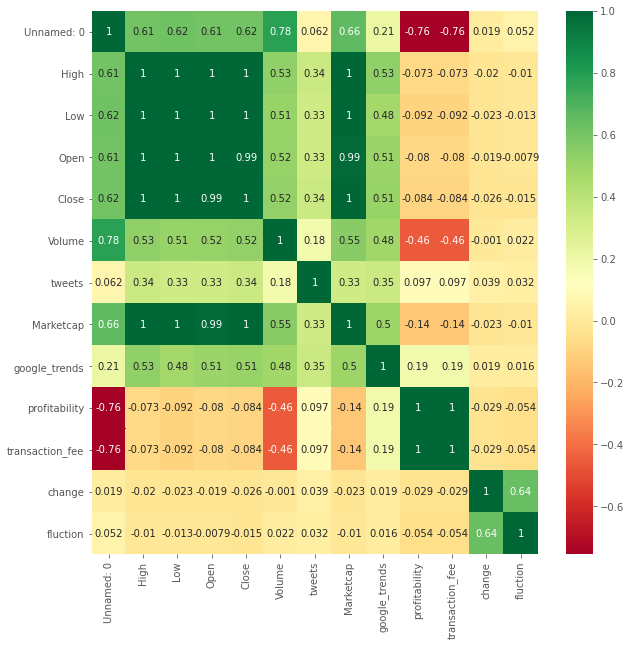

In [2]:
filepath = f"./data/ETH_Data.csv"

keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction']

targets = ["fluction"]
ETH_df = pd.read_csv(filepath, infer_datetime_format=True,
                         parse_dates=True)
ETH_df=ETH_df.fillna(0)
corrmat = ETH_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
ax=sns.heatmap(ETH_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()


In [3]:

#ETH_df=ETH_df.set_index("Date")
keys=['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee', 'fluction']
series = ETH_df[keys]
# Picking the series with high correlation
#series.shape
series.tail(2)

,Close,Volume,tweets,google_trends,profitability,transaction_fee,fluction
1007,19142.382534,2.545047e+10,39491.0,61.014,0.140,0.140,0.00545
1008,19246.644341,2.247400e+10,38737.0,58.859,0.131,0.131,0.00000


## Price Predictions via three layers LSTM

In [4]:
%reload_ext autoreload
%autoreload 1
%aimport LSTM_pytorch
from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch


In [5]:
hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 100

keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee', 'fluction']
targets = ["fluction"]


scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(filepath=filepath,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)


In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])


Model 1:


/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 99. Loss: 0.004747830457818732. val_loss: 0.00790390952611364.
Training time: 39.1270387172699
Model 2:


In [ ]:
%reload_ext autoreload
%autoreload 1
%aimport DataFun
from DataFun import *

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
LSTM_prediction_record=prediction_record
LSTM_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record = LSTM_prediction_record

In [ ]:
PATH='./model/LSTM_Naive_ETH_min_mse.pt'
PATH2='./model/LSTM_Naive_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


### total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(filepath=filepath,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
total_model_record=None

total_model_record=pd.DataFrame(columns=["model","score","sentiment_method","MSE","RMSE","R2"])


In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM","score":score,"sentiment_method": "no sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

## price prediction model: three layer LSTM + sentiment indices from different "BERT" model

### Baseline: LM

In [ ]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 100

file_sentiment=f'./data/LM_dic_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
LM_df=pd.concat([df, sentiment['sentiment']], axis=1, join='inner')
keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
LM_df=LM_df[keys]


In [ ]:
LM_scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, LM_scaler) = LSTM_pytorch.dataloading(
                                                    df= LM_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)


In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])


In [ ]:
%reload_ext autoreload
%autoreload 1
%aimport DataFun
from DataFun import *

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+LM",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
LM_prediction_record=prediction_record
LM_prediction_record

In [ ]:
total_record = total_record.append(LM_prediction_record,ignore_index=True)

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
PATH='./model/LSTM_LM_ETH_min_mse.pt'
PATH2='./model/LSTM_LM_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


### LM: total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=LM_df,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)


In [ ]:

predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)


In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+LM","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)


In [ ]:

score="R2"
total_model_record=total_model_record.append({"model":"LSTM+LM","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

### RoBERTa

In [ ]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 50

file_sentiment=f'./data/_roberta_fold_9_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
RoBERTa_df=pd.concat([df, sentiment],axis=1, join='inner')


#### RoBERTa: sentiment without probability

In [ ]:
keys = ['Close', 'Volume', 'tweets', 'google_trends',
        'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]

RoBERTa_df_sentiment=RoBERTa_df[keys]

Ro_sen_scaler=MinMaxScaler()

(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, Ro_sen_scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)



In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM_RoBERT_s",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
Ro_sen_prediction_record=prediction_record
Ro_sen_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record = total_record.append(Ro_sen_prediction_record)

In [ ]:
PATH='./model/LSTM_RoBERTa_sen_ETH_min_mse.pt'
PATH2='./model/LSTM_RoBERTa_sen_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


#### RoBERTa_s: total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=RoBERTa_df_sentiment,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+RoBERTa_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+RoBERTa_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

#### RoBERTa: sentiment with probabilities


In [ ]:
keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee', 'fluction','preds']
targets = ["fluction"]
RoBERTa_df_preds=RoBERTa_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df_preds,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)


In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:
%reload_ext autoreload
%autoreload 1
%aimport DataFun
from DataFun import *

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+RoBERTa_p",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
RoBERTa_p_prediction_record=prediction_record
RoBERTa_p_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record=total_record.append(RoBERTa_p_prediction_record, ignore_index=True)

#### RoBERTa_p: total dataset prediction performance

In [ ]:
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=RoBERTa_df_preds,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+Roberta_p","score":score,"sentiment_method": "preds",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+Roberta_p","score":score,"sentiment_method": "preds",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

## DistilBERT

In [ ]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 50

file_sentiment=f'./data/_distilbert_fold_2_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
Distil_df=pd.concat([df, sentiment],axis=1, join='inner')

#### DistilBERT: sentiment without probabilities

In [ ]:
keys = ['Close', 'Volume', 'tweets', 'google_trends',
        'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
Distil_df_sentiment=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=Distil_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)



In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+DistilBERT_s",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
DistilBERT_s_prediction_record=prediction_record
DistilBERT_s_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record=total_record.append(DistilBERT_s_prediction_record,ignore_index=True)

In [ ]:
PATH='./model/LSTM_Distil_s_ETH_min_mse.pt'
PATH2='./model/LSTM_Distil_s_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


#### DistileBERT_s: total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=Distil_df_sentiment,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)



In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+DistilBERT_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+DistilBERT_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

#### DistilBERT: sentiment with probabilities

In [ ]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability',
        'transaction_fee', 'fluction','preds']
targets = ["fluction"]
Distil_df_preds=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=Distil_df_preds,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)


In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+Distil_p",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
Distil_s_prediction_record=prediction_record
Distil_s_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record=total_record.append(Distil_s_prediction_record, ignore_index=True)

In [ ]:
PATH='./model/LSTM_DistilBERT_p_ETH_min_mse.pt'
PATH2='./model/LSTM_DistilBERT_p_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


#### DistileBERT_p: total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=Distil_df_preds,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+DistilBERT_p","score":score,
                                              "sentiment_method": "preds",
                                              "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+DistilBERT_p","score":score,
                                              "sentiment_method": "preds",
                                              "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

## FinBERT

In [ ]:
hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 50

file_sentiment=f'./data/FinBert_pre_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')
FinBERT_df=pd.concat([df, sentiment],axis=1, join='inner')

### FinBERT: sentiment without probability

In [ ]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability',
        'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
FinBERT_df_sentiment=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)

In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])

fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM_RoBERT_s",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
FinBERT_sen_prediction_record=prediction_record
FinBERT_sen_prediction_record

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model_max_r2,_,_=training_record[index_max_r]

In [ ]:
total_record = total_record.append(FinBERT_sen_prediction_record,ignore_index=True)

In [ ]:
PATH='./model/LSTM_FinBERT_sen_ETH_min_mse.pt'
PATH2='./model/LSTM_FinBERT_sen_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


#### FinBERT: total dataset prediction performance

In [ ]:

scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=FinBERT_df_sentiment,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+FinBERT_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+FinBERT_s","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

### FinBERT: sentiment with probabilities

In [ ]:
keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee', 'fluction','preds']
targets = ["fluction"]
FinBERT_df_preds=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_preds,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)


In [ ]:
training_record=[]
for i in range(10):
    print("Model {}:".format(i+1))
    model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                     seq_dim=seq_dim,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     hidden_dim=hidden_dim,
                                                     layer_dim=layer_dim,
                                                     output_dim=output_dim,
                                                     num_epochs = num_epochs)
    training_record.append([model,train_loss,val_loss])

In [ ]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
plt.legend(['train','val'],loc = 'upper right')
index=0
for model,train_loss,val_loss in training_record:
    axs[int(index/2),index%2].plot(train_loss)
    axs[int(index/2),index%2].plot(val_loss)
    axs[int(index/2),index%2].set_title("Model {}".format(index))
    index+=1

In [ ]:
prediction_record=None
prediction_record=pd.DataFrame(columns=["model_name","model","MSE","RMSE","R2"])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 14.5)
for index,record in enumerate(training_record):
    model,_,_=record
    predicted, actual,mse,r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
    prediction_record=prediction_record.append({"model_name":"LSTM+FinBERT_p",
                                                "model":index,
                                                "MSE":mse.item(),
                                                "RMSE":rmse,"R2":r}, ignore_index=True)

    axs[int(index/2),index%2].plot(predicted,c = 'r')
    axs[int(index/2),index%2].plot(actual,c = 'y')
    axs[int(index/2),index%2].set_title("Model {}".format(index))


In [ ]:
FinBERT_p_prediction_record=prediction_record
FinBERT_p_prediction_record

In [ ]:
total_record = total_record.append(FinBERT_p_prediction_record,ignore_index=True)

In [ ]:
index_min_mse= min(range(len(prediction_record["MSE"])), key=prediction_record["MSE"].__getitem__)
index_max_r= max(range(len(prediction_record["R2"])), key=prediction_record["R2"].__getitem__)
modle_min_mse,_,_=training_record[index_min_mse]
model__max_r2,_,_=training_record[index_max_r]

In [ ]:
PATH='./model/LSTM_FinBERT_p_ETH_min_mse.pt'
PATH2='./model/LSTM_FinBERT_p_ETH_max_r2.pt'
# Save a model
torch.save(modle_min_mse.state_dict(),PATH)
torch.save(model_max_r2.state_dict(),PATH2)


### FinBERT_p: total dataset prediction performance

In [ ]:
scaler=MinMaxScaler()
(input_dim,df_dataset, scaler) = LSTM_pytorch.dataloading_total(df=FinBERT_df_preds,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
data_loader = torch.utils.data.DataLoader(dataset=df_dataset,
                                          batch_size=1,
                                          shuffle=True)


In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, modle_min_mse)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
score="MSE"
total_model_record=total_model_record.append({"model":"LSTM+FinBERT_p","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

In [ ]:
predicted, actual, mse,r,rmse = LSTM_pytorch.LSTM_predict(data_loader, model_max_r2)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)


In [ ]:
score="R2"
total_model_record=total_model_record.append({"model":"LSTM+FinBERT_p","score":score,"sentiment_method": "sentiment",
                      "MSE":mse.item(),"RMSE":rmse,"R2":r}, ignore_index=True)

## Performance Comparison

In [ ]:
total_model_record

In [ ]:
total_model_record[total_model_record["score"]=="MSE"][total_model_record["sentiment_method"] == "sentiment"]

In [ ]:
total_model_record[total_model_record["score"]=="R2"]

In [ ]:
total_record